In [1]:
import os, sys
sys.path.append("/content")
from src.utils import fit_mlp, plot_obs_predict

with open("/content/credentials") as f:
    env_vars = f.read().split("\n")

for var in env_vars:
    key, value = var.split(" = ")
    os.environ[key] = value

storage_options = {"account_name":os.environ["ACCOUNT_NAME"],
                   "account_key":os.environ["BLOB_KEY"]}


In [2]:
# Specify hyperparameters and fit model
buffer_distance = 500
day_tolerance = 8
cloud_thr = 80
min_water_pixels = 20
features = [
    "Intercept", "sentinel-2-l2a_AOT", 
    "sentinel-2-l2a_B02", "sentinel-2-l2a_B03", "sentinel-2-l2a_B04", # RGB bands
    "sentinel-2-l2a_B08", # NIR
    #"sentinel-2-l2a_WVP", 
    "sentinel-2-l2a_B05", "sentinel-2-l2a_B06", "sentinel-2-l2a_B07", "sentinel-2-l2a_B8A",  # Red edge bands
    "is_brazil", #"sine_julian", 
    "sentinel-2-l2a_B11", "sentinel-2-l2a_B12", # SWIR
    "mean_viewing_azimuth", "mean_viewing_zenith",
    "mean_solar_azimuth", "mean_solar_zenith"
]
epochs = 1000
batch_size = 32
learning_rate = 0.005

layer_out_neurons = [12, 24, 6]
n_layers = len(layer_out_neurons)

model_out = fit_mlp(
    features,
    learning_rate,
    batch_size,
    epochs,
    storage_options,
    buffer_distance=buffer_distance,
    day_tolerance=day_tolerance,
    cloud_thr=cloud_thr,
    mask_method1="lulc",
    mask_method2="ndvi",
    min_water_pixels=min_water_pixels,
    layer_out_neurons=layer_out_neurons
)

Begin training.
Epoch 10/1000 | Train Loss: 0.45878 | Val Loss: 0.61653
Epoch 20/1000 | Train Loss: 0.39907 | Val Loss: 0.54437
Epoch 30/1000 | Train Loss: 0.38836 | Val Loss: 0.52653
Epoch 40/1000 | Train Loss: 0.37708 | Val Loss: 0.53085
Epoch 50/1000 | Train Loss: 0.36802 | Val Loss: 0.52657
Epoch 60/1000 | Train Loss: 0.36140 | Val Loss: 0.51641
Epoch 70/1000 | Train Loss: 0.34458 | Val Loss: 0.54461
Epoch 80/1000 | Train Loss: 0.35632 | Val Loss: 0.52140
Epoch 90/1000 | Train Loss: 0.33356 | Val Loss: 0.49136
Epoch 100/1000 | Train Loss: 0.33826 | Val Loss: 0.49725
Epoch 110/1000 | Train Loss: 0.31739 | Val Loss: 0.51936
Epoch 120/1000 | Train Loss: 0.31036 | Val Loss: 0.51033
Epoch 130/1000 | Train Loss: 0.32004 | Val Loss: 0.52303
Epoch 140/1000 | Train Loss: 0.30785 | Val Loss: 0.50516
Epoch 150/1000 | Train Loss: 0.31140 | Val Loss: 0.52395
Epoch 160/1000 | Train Loss: 0.31628 | Val Loss: 0.52731
Epoch 170/1000 | Train Loss: 0.31084 | Val Loss: 0.55323
Epoch 180/1000 | Train L

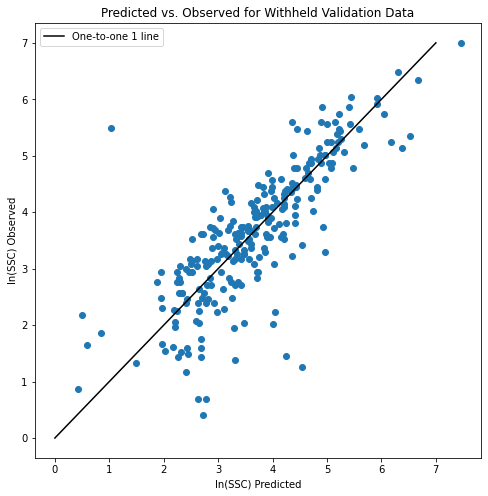

In [241]:
# Plot observed vs predicted for Test data
plot_obs_predict(
    model_out["val_obs_predict"],
    title="Predicted vs. Observed for Withheld Validation Data",
    savefig=False)

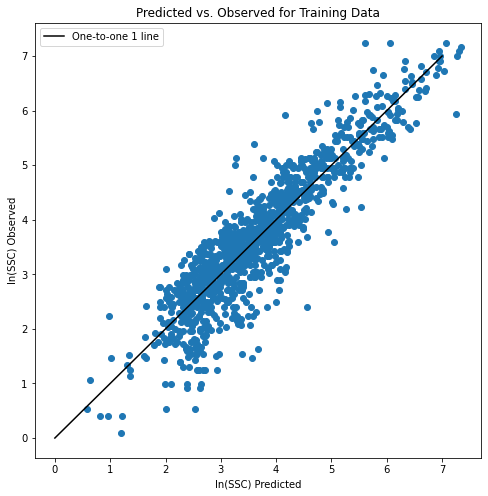

In [242]:
# Plot observed vs predicted for Train data
plot_obs_predict(
    model_out["train_obs_predict"],
    title="Predicted vs. Observed for Training Data",
    savefig=False)

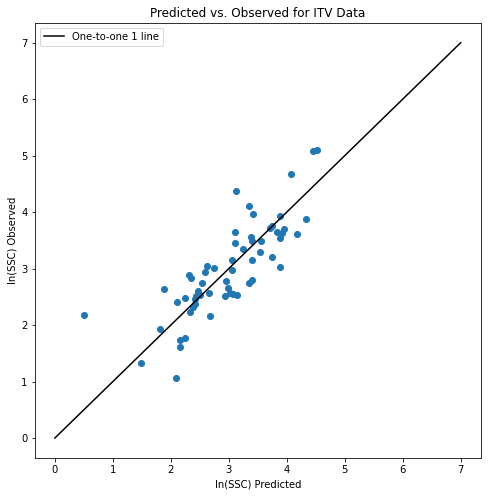

In [243]:
# Plot observed vs predicted for ITV data
plot_obs_predict(
    model_out["itv_obs_predict"],
    title="Predicted vs. Observed for ITV Data",
    savefig=False)

In [244]:
print(model_out["train_R2"])
print(model_out["val_R2"])
print(model_out["itv_R2"])

0.7844104796404638
0.5696157488755169
0.5970007234657535


In [248]:
###### Make pixel-level predictions
import pandas as pd, numpy as np, rasterio as rio
fp = f"az://modeling-data/partitioned_feature_data_buffer500m_daytol8_cloudthr80percent_lulcndvi_masking.csv"
data = pd.read_csv(fp, storage_options=storage_options)

not_enough_water = data["n_water_pixels"] <= min_water_pixels
data.drop(not_enough_water[not_enough_water].index, inplace=True)
data["Log SSC (mg/L)"] = np.log(data["SSC (mg/L)"])

lnssc_0 = data["Log SSC (mg/L)"] == 0
data.drop(lnssc_0[lnssc_0].index, inplace=True)

sentinel_features = [x for x in features if "sentinel" in x]
non_sentinel_features = [x for x in features if "sentinel" not in x]
observation = data.reset_index().loc[list(data["sample_id"]).index("0000ITV6_00000017"), :]
features


['Intercept',
 'sentinel-2-l2a_AOT',
 'sentinel-2-l2a_B02',
 'sentinel-2-l2a_B03',
 'sentinel-2-l2a_B04',
 'sentinel-2-l2a_B08',
 'sentinel-2-l2a_B05',
 'sentinel-2-l2a_B06',
 'sentinel-2-l2a_B07',
 'sentinel-2-l2a_B8A',
 'is_brazil',
 'sentinel-2-l2a_B11',
 'sentinel-2-l2a_B12',
 'mean_viewing_azimuth',
 'mean_viewing_zenith',
 'mean_solar_azimuth',
 'mean_solar_zenith']

In [249]:
RIO_BANDS_ORDERED = {
    "sentinel-2-l2a_AOT":1, 
    "sentinel-2-l2a_B02":2, 
    "sentinel-2-l2a_B03":3, 
    "sentinel-2-l2a_B04":4, 
    "sentinel-2-l2a_B08":5, 
    "sentinel-2-l2a_WVP":6,
    "sentinel-2-l2a_B05":7, 
    "sentinel-2-l2a_B06":8, 
    "sentinel-2-l2a_B07":9, 
    "sentinel-2-l2a_B8A":10, 
    "sentinel-2-l2a_B11":11, 
    "sentinel-2-l2a_B12":12
}

with rio.Env(
    AZURE_STORAGE_ACCOUNT=os.environ["ACCOUNT_NAME"], 
    AZURE_STORAGE_ACCESS_KEY=os.environ["BLOB_KEY"]
):
    with rio.open(observation["raw_img_chip_href"]) as ds:
        img = ds.read([RIO_BANDS_ORDERED[x] for x in sentinel_features])
    with rio.open(observation["water_chip_href"]) as ds:
        water = ds.read(1)


In [250]:
non_sentinel_values = list(observation[non_sentinel_features[1:]])

In [251]:
import torch
def predict_pixel_ssc(sentinel_values, sentinel_features, non_sentinel_values, non_sentinel_features, all_features, scaler, model):
    obs_dict = dict.fromkeys(all_features)
    obs_dict.update(zip(sentinel_features, sentinel_values))
    obs_dict.update(zip(non_sentinel_features, [1] + non_sentinel_values))
    feature_values = torch.Tensor(
        list(
            scaler.transform(
                np.array(
                    list(obs_dict.values()), ndmin=2
                    )
                )[0, :]
            )
        )
    with torch.no_grad():
        model.eval()
        y_pred = model(feature_values).squeeze().numpy()

    return np.exp(y_pred.item())

In [252]:
predictions = np.empty(water.shape)
predictions[(water == False)] = np.NaN
predictions[(water == True)] = np.apply_along_axis(predict_pixel_ssc, 0, img[:, (water == True)], sentinel_features, non_sentinel_values, non_sentinel_features, features, model_out["scaler"], model_out["model"])


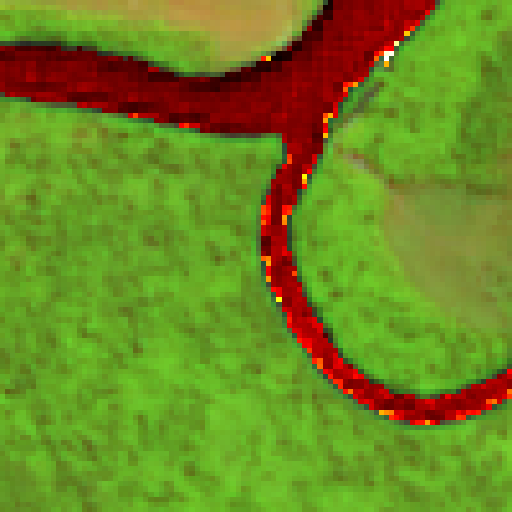

In [253]:
from matplotlib import pyplot as plt
from PIL import Image
cm = plt.get_cmap('hot')

ssc = (cm(np.interp(predictions, (np.nanmin(predictions), np.nanmax(predictions)), (0, 1))) * 255).astype(np.uint8)[:,:, 0:3]
mean_pred = np.nanmean(predictions)
observed = observation["Log SSC (mg/L)"]

img2 =  np.moveaxis(
    np.interp(
        np.clip(
            img[[9,4,2], :, :], 
            0,
            6000
        ), 
        (0, 6000),
        (0, 1)
    ) ** 0.7 * 255,
    0,
    2
).astype(np.uint8)

img2[(water == True), :] = ssc[(water == True), :]

img2_pil = Image.fromarray(img2)
img2_pil.resize((512, 512), Image.NEAREST).show()

In [200]:
print((mean_pred, observed))

(2.4935895497824214, 3.051639905492287)
